# Anàlisis de severitat

En aquesta part del TFM aplicarem diferents mètodes supervisats i tractarem d'optimitzar diferents mètriques amb l'objectiu de classificar els accidents localitzats, amb la major precisió possible, segons la severitat de l'accident i a través de les dades sobre mesures del mateix (límit de velocitat de la zona, nombre de vehícles en l'esdeveniment, nombre de persones en l'esdeveniment, tipus d'accident, estat de la carretera) i amb les dades mediambientals (temperatura, llum, humitat).

Algorismes supervisats que utilitzare:

    1 - K-NN
    2 - Super Vector Machine 
    3 - Arbre de decisió
    4 - Random Forest
    5 - Gradient Boosting

In [1]:
# Importació de llibreries
from io import StringIO
from IPython.display import Image
import matplotlib as mpl
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from codecarbon import EmissionsTracker
import timeit
# import pydotplus
import seaborn as sns
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.inspection import permutation_importance
import platform
import psutil
import json
import random

In [2]:
random.seed(111)

In [3]:
# Càrrega de dades
acc_meas = pd.read_csv("measures_accidents_localitzats.csv")

cat_type_veh = pd.CategoricalDtype(categories=[1,2,3,4,5,6], ordered=True)
cat_type_per = pd.CategoricalDtype(categories=[1,2,3,4,5,6,7,8,9,10], ordered=True)
cat_type_sev = pd.CategoricalDtype(categories=[3,2,1], ordered=True)

# creating instance of one-hot-encoder
enc = OneHotEncoder(handle_unknown='ignore')

enc_df = pd.DataFrame(enc.fit_transform(acc_meas[['SPEED_ZONE']]).toarray())
enc_df = enc_df.rename(columns = {0 : 'SZ_40'
                                 ,1: 'SZ_50'
                                 ,2: 'SZ_60'
                                 ,3: 'SZ_70'
                                 ,4: 'SZ_80'
                                 ,5: 'SZ_100'
                                 ,6: 'SZ_NULL' })


acc_meas = acc_meas.join(enc_df)

# Modifiquem tipus
acc_meas = acc_meas.astype({'ACCIDENT_TYPE': 'category'
                              ,'NO_OF_VEHICLES': cat_type_veh
                              ,'NO_PERSONS': cat_type_per
                              ,'SEVERITY':cat_type_sev
                              ,'SURFACE_COND': 'category'
                              ,'SZ_40': 'category'
                              ,'SZ_50': 'category'
                              ,'SZ_60': 'category'
                              ,'SZ_70': 'category'
                              ,'SZ_80': 'category'
                              ,'SZ_100': 'category'})



#Normalitzem
scaler = MinMaxScaler()
acc_meas_df = scaler.fit_transform(acc_meas[['temp_avg', 'light_avg','humidity_avg']])
acc_meas_df = pd.DataFrame(acc_meas_df, columns=['temp_avg_scale', 'light_avg_scale', 'humidity_avg_scale'])
acc_meas = pd.concat([acc_meas, acc_meas_df], axis=1)

# Dividim el conjunt de dades
X = acc_meas[['SURFACE_COND','ACCIDENT_TYPE', 'SZ_40','SZ_50','SZ_60','SZ_70','SZ_80','SZ_100', 'NO_OF_VEHICLES', 'NO_PERSONS', 'temp_avg_scale', 'light_avg_scale', 'humidity_avg_scale']]
y = acc_meas['SEVERITY']


X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)

In [4]:
def getSystemInfo():
    try:
        info={}
        info['platform']=platform.system()
        info['platform-release']=platform.release()
        info['platform-version']=platform.version()
        info['node-name']=platform.node()
        info['architecture']=platform.machine()
        info['processor']=platform.processor()
        info['ram']=str(round(psutil.virtual_memory().total / (1024.0 **3)))+" GB"
        return json.dumps(info)
    except Exception as e:
        logging.exception(e)

json.loads(getSystemInfo())

{'platform': 'Linux',
 'platform-release': '5.4.0-122-generic',
 'platform-version': '#138-Ubuntu SMP Wed Jun 22 15:00:31 UTC 2022',
 'node-name': 'JptHub01',
 'architecture': 'x86_64',
 'processor': 'x86_64',
 'ram': '31 GB'}

Cap de les variables numèriques mostren una correlació superior al 90%; per tant, la única variable que hem eliminar ha sigut la SZ_NULL, és a dir, les zones de velocitat no recollides. D'aquesta manera, també eliminem la col·linealitat d'aquestes variables "SZ" una vegada transformades a One Hot.

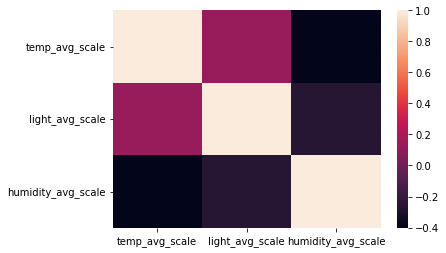

In [5]:
data_corr = X.corr()
ax = sns.heatmap(data_corr)

## K - Nearest Neighbours (K-NN)

El primer algoritme que utilitzarem per a classificar els punts és el  k-nn. Tindrem en compte dos hiperparàmetres del algoritme per obtenir la major precisió.

- **k**: és el nombre de veïns més propers. Provarem tots els valors entre 1 i 10
- **pesos**: importància que es dona a cadascun dels veïns considerats. Provarem "uniforme", on tots els veïns tindran el mateix pes, i pesos segons distància ("distance"), on els veïns més propers tindran més pes.

In [6]:
# Establim els paràmetres
k     = list(range(1,11))
pesos = ['uniform','distance']
hiperParam = dict(n_neighbors=k, weights=pesos)

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"


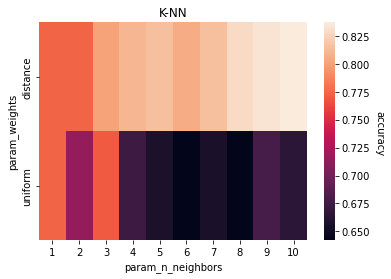

In [7]:
# Generem el model
knn = KNeighborsClassifier(n_neighbors=10)

# Apliquem GridSearchCV
grid = GridSearchCV(knn, 
                    param_grid=hiperParam, 
                    cv=4, 
                    scoring='accuracy')

# Entrenem
grid.fit(X_train, y_train)

# Resultat
# Aquest és el resultat obtingut
result_pvt = pd.pivot_table(pd.DataFrame(grid.cv_results_),
         values='mean_test_score', index='param_weights', columns='param_n_neighbors')

ax = plt.axes()
ax.text(12.5,1.20,'accuracy', rotation = 270)
sns.heatmap(result_pvt, ax = ax )     
ax.set_title('K-NN')
plt.show()

In [8]:
result_pvt

param_n_neighbors,1,2,3,4,5,6,7,8,9,10
param_weights,,,,,,,,,,
distance,0.773864,0.773864,0.801055,0.810065,0.814529,0.805357,0.814448,0.828084,0.832549,0.837094
uniform,0.773864,0.715260,0.769399,0.674107,0.656250,0.642370,0.655925,0.642370,0.678734,0.665179


Notem que k = 10 i pes distància obtenim una major precisió

In [9]:
# Apliquem l'hiperparàmetre amb major precisió i entrenem
knn = KNeighborsClassifier(n_neighbors=10, weights='distance')

# Codecarbon + timeit

tracker = EmissionsTracker()

tracker.start()
starttime = timeit.default_timer()

knn.fit(X_train, y_train)

time = timeit.default_timer() - starttime

emissions: float = tracker.stop()

# Apliquem predict sobre test
y_pred = knn.predict(X_test)

# Pintem l'accuracy del model i la matriu de confusió
print("RESULTAT K-NN :")
print('- Accuracy: {}'.format(round(accuracy_score(y_test, y_pred)*100, 3)))
print('- Emissions C02: {}'.format(emissions))
print('- Temps: {}'.format(time))

[codecarbon INFO @ 20:47:19] [setup] RAM Tracking...
[codecarbon INFO @ 20:47:19] [setup] GPU Tracking...
[codecarbon INFO @ 20:47:19] No GPU found.
[codecarbon INFO @ 20:47:19] [setup] CPU Tracking...
[codecarbon WARNING @ 20:47:19] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 20:47:21] We saw that you have a Intel(R) Xeon(R) CPU E5-2630 v3 @ 2.40GHz but we don't know it. Please contact us.
[codecarbon INFO @ 20:47:21] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU E5-2630 v3 @ 2.40GHz
[codecarbon INFO @ 20:47:21] >>> Tracker's metadata:
[codecarbon INFO @ 20:47:21]   Platform system: Linux-5.4.0-122-generic-x86_64-with-glibc2.29
[codecarbon INFO @ 20:47:21]   Python version: 3.8.10
[codecarbon INFO @ 20:47:21]   Available RAM : 31.360 GB
[codecarbon INFO @ 20:47:21]   CPU count: 8
[codecarbon INFO @ 20:47:21]   CPU model: Intel(R) Xeon(R) CPU E5-2630 v3 @ 2.40GHz
[codecarbon INFO @ 20:47:21]   GPU count: None
[codecarbon INFO @ 20

RESULTAT K-NN :
- Accuracy: 82.143
- Emissions C02: 2.1352524149038905e-08
- Temps: 0.0049928706139326096


## Super Vector Machine (SVM)

El segon algoritme que utilitzarem és SVM a través de la kernel radial. En aquest cas els hiperparàmetres a optimitzar són:

- **C**: Valor de penalització dels errors en al classificació. Provarem entre els valors 0.01, 0.1, 1, 10, 50, 100 i 200.
- **gamma**: Coeficient que multiplica la distància entre dos punts al kernel radial.

In [10]:
# Establim els paràmetres
C_param     = [0.01, 0.1, 1, 10, 50, 100, 200]
gamma_param = [0.001, 0.01, 0.1, 1, 10]
hiperParam = dict(C=C_param, gamma=gamma_param)

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"


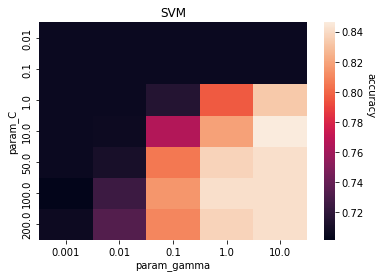

In [11]:
# Generem el model
classifier = svm.SVC(kernel="rbf")

# Apliquem GridSearchCV
grid = GridSearchCV(classifier, 
                    param_grid=hiperParam, 
                    cv=4, 
                    scoring='accuracy')

grid.fit(X_train, y_train)
grid.cv_results_

# Resultat
result_pvt = pd.pivot_table(pd.DataFrame(grid.cv_results_),
         values='mean_test_score', index='param_C', columns='param_gamma')

ax = plt.axes()
ax.text(6.1,3.,'accuracy', rotation = 270)
sns.heatmap(result_pvt, ax = ax )
ax.set_title('SVM')
plt.show()

C = 10 i gamma = 10

In [12]:
result_pvt

param_gamma,0.001,0.010,0.100,1.000,10.000
param_C,,,,,
0.01,0.705925,0.705925,0.705925,0.705925,0.705925
0.10,0.705925,0.705925,0.705925,0.705925,0.705925
1.00,0.705925,0.705925,0.715097,0.796347,0.832630
10.00,0.705925,0.706006,0.764854,0.818994,0.846185
50.00,0.705925,0.710552,0.805438,0.837094,0.841640
100.00,0.701461,0.724107,0.814529,0.841640,0.841640
200.00,0.706006,0.733036,0.809903,0.837094,0.841640


In [13]:
# Apliquem l'hiperparàmetre amb major precisió i entrenem
classifier = svm.SVC(kernel="rbf", C=10, gamma=10, probability=True)

# Codecarbon + timeit

tracker = EmissionsTracker()

tracker.start()
starttime = timeit.default_timer()

classifier.fit(X_train, y_train)

time = timeit.default_timer() - starttime

emissions: float = tracker.stop()

# Apliquem predict sobre test
y_pred = classifier.predict(X_test)

# Pintem l'accuracy del model i la matriu de confusió
print("RESULTAT SVM :")
print('- Accuracy: {}'.format(round(accuracy_score(y_test, y_pred)*100, 3)))
print('- Emissions C02: {}'.format(emissions))
print('- Temps: {}'.format(time))

[codecarbon INFO @ 20:47:24] [setup] RAM Tracking...
[codecarbon INFO @ 20:47:24] [setup] GPU Tracking...
[codecarbon INFO @ 20:47:24] No GPU found.
[codecarbon INFO @ 20:47:24] [setup] CPU Tracking...
[codecarbon WARNING @ 20:47:24] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 20:47:26] We saw that you have a Intel(R) Xeon(R) CPU E5-2630 v3 @ 2.40GHz but we don't know it. Please contact us.
[codecarbon INFO @ 20:47:26] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU E5-2630 v3 @ 2.40GHz
[codecarbon INFO @ 20:47:26] >>> Tracker's metadata:
[codecarbon INFO @ 20:47:26]   Platform system: Linux-5.4.0-122-generic-x86_64-with-glibc2.29
[codecarbon INFO @ 20:47:26]   Python version: 3.8.10
[codecarbon INFO @ 20:47:26]   Available RAM : 31.360 GB
[codecarbon INFO @ 20:47:26]   CPU count: 8
[codecarbon INFO @ 20:47:26]   CPU model: Intel(R) Xeon(R) CPU E5-2630 v3 @ 2.40GHz
[codecarbon INFO @ 20:47:26]   GPU count: None
[codecarbon INFO @ 20

RESULTAT SVM :
- Accuracy: 87.5
- Emissions C02: 7.906034030337296e-08
- Temps: 0.025455191731452942


## Arbre de decisió

El tercer algoritme serà un arbre de decisió. En aquest cas els hiperparàmetres seran:
- **max_depth:** profunditat màxima de l'arbre. Utilitzarem els valors entre 4 i 10
- **min_samples_split:** mínim nombre d'observacions que ha de tenir una fulla de l'arbre per dividir-se. Observarem 2, 10, 20, 50 i 100.

In [14]:
# Establim els paràmetres
max_depth_param         = list(range(4,11))
min_samples_split_param = [2, 10, 20, 50, 100]
hiperParam = dict(max_depth = max_depth_param, min_samples_split = min_samples_split_param)

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"


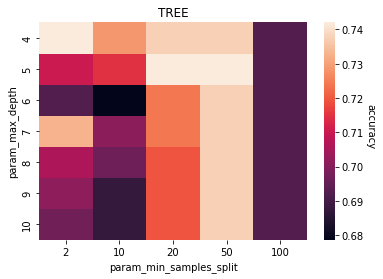

In [15]:
# Generem el model
tree = DecisionTreeClassifier(random_state = 100)

# Apliquem GridSearchCV
grid = GridSearchCV(tree, 
                    param_grid=hiperParam, 
                    cv=4, 
                    scoring='accuracy')

grid.fit(X_train, y_train)
grid.cv_results_

# Resultat
result_pvt = pd.pivot_table(pd.DataFrame(grid.cv_results_),
         values='mean_test_score', index='param_max_depth', columns='param_min_samples_split')

ax = plt.axes()
sns.heatmap(result_pvt, ax = ax )
ax.text(6.1,4,'accuracy', rotation = 270)
ax.set_title('TREE')
plt.show()

In [16]:
result_pvt

param_min_samples_split,2,10,20,50,100
param_max_depth,,,,,
4,0.741964,0.728490,0.737581,0.737581,0.69237
5,0.710146,0.714773,0.742045,0.742045,0.69237
6,0.692208,0.678653,0.724026,0.737500,0.69237
7,0.732792,0.701136,0.724026,0.737500,0.69237
8,0.705682,0.696591,0.719481,0.737500,0.69237
9,0.701218,0.687500,0.719481,0.737500,0.69237
10,0.696834,0.687500,0.719481,0.737500,0.69237


S'observa que els millors resultats s'han obtingut amb una profunditat ("max_depth") de 5 i un "min_samples_split" de 20 i 50

In [17]:
# Apliquem l'hiperparàmetre amb major precisió i entrenem
tree = DecisionTreeClassifier(max_depth = 5, min_samples_split = 20, random_state = 100)

# Codecarbon + timeit

tracker = EmissionsTracker()

tracker.start()
starttime = timeit.default_timer()

tree.fit(X_train, y_train)

time = timeit.default_timer() - starttime

emissions: float = tracker.stop()

# Apliquem predict sobre test
y_pred = tree.predict(X_test)

# Pintem l'accuracy del model i la matriu de confusió
print("RESULTAT TREE :")
print('- Accuracy: {}'.format(round(accuracy_score(y_test, y_pred)*100, 3)))
print('- Emissions C02: {}'.format(emissions))
print('- Temps: {}'.format(time))

[codecarbon INFO @ 20:47:30] [setup] RAM Tracking...
[codecarbon INFO @ 20:47:30] [setup] GPU Tracking...
[codecarbon INFO @ 20:47:30] No GPU found.
[codecarbon INFO @ 20:47:30] [setup] CPU Tracking...
[codecarbon WARNING @ 20:47:30] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 20:47:32] We saw that you have a Intel(R) Xeon(R) CPU E5-2630 v3 @ 2.40GHz but we don't know it. Please contact us.
[codecarbon INFO @ 20:47:32] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU E5-2630 v3 @ 2.40GHz
[codecarbon INFO @ 20:47:32] >>> Tracker's metadata:
[codecarbon INFO @ 20:47:32]   Platform system: Linux-5.4.0-122-generic-x86_64-with-glibc2.29
[codecarbon INFO @ 20:47:32]   Python version: 3.8.10
[codecarbon INFO @ 20:47:32]   Available RAM : 31.360 GB
[codecarbon INFO @ 20:47:32]   CPU count: 8
[codecarbon INFO @ 20:47:32]   CPU model: Intel(R) Xeon(R) CPU E5-2630 v3 @ 2.40GHz
[codecarbon INFO @ 20:47:32]   GPU count: None
[codecarbon INFO @ 20

RESULTAT TREE :
- Accuracy: 73.214
- Emissions C02: 2.2012385256725038e-08
- Temps: 0.0056385500356554985


## Random Forest

Aplicarem un algoritme Random Forest. Els paràmetres que utilitzarem seran:
- **max_depth**: la profunditat màxima de l'arbre. Explorarem els valors entre 4 i 13.
- **n_estimators**: nombre d'arbres. Explorarem els valors 10, 20, 50, 100 i 200 

In [18]:
# Establim els paràmetres
max_depth_param    = list(range(4,13))
n_estimators_param = [10, 20, 50, 100, 200]
hiperParam = dict(max_depth = max_depth_param, n_estimators = n_estimators_param)

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"


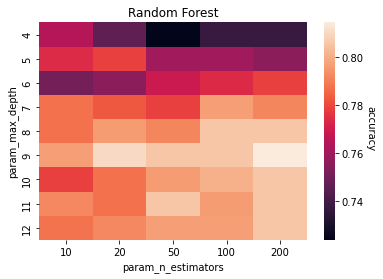

In [19]:
# Generem el model que volem
classif= RandomForestClassifier(random_state = 100)

# Apliquem GridSearchCV
grid = GridSearchCV(classif, 
                    param_grid=hiperParam, 
                    cv=4, 
                    scoring='accuracy')

grid.fit(X_train, y_train)
grid.cv_results_


# Aquest és el resultat obtingut
result_pvt = pd.pivot_table(pd.DataFrame(grid.cv_results_),
         values='mean_test_score', index='param_max_depth', columns='param_n_estimators')


ax = plt.axes()
ax.text(6.1,5.2,'accuracy', rotation = 270)
sns.heatmap(result_pvt, ax = ax )
ax.set_title('Random Forest')
plt.show()

In [20]:
result_pvt

param_n_estimators,10,20,50,100,200
param_max_depth,,,,,
4,0.764610,0.746510,0.723945,0.737500,0.737500
5,0.773945,0.778247,0.760065,0.760065,0.755438
6,0.751136,0.755601,0.769156,0.773620,0.778166
7,0.787500,0.782792,0.778328,0.796510,0.791802
8,0.787338,0.796429,0.791802,0.805519,0.805438
9,0.796672,0.810065,0.805438,0.805519,0.814529
10,0.778409,0.787500,0.796347,0.800974,0.805519
11,0.792208,0.787500,0.805357,0.796429,0.805519
12,0.787662,0.792045,0.796591,0.796510,0.805519


El millor resultats s'han obtingut amb un n_estimators = 200 i una profunditat de 9

In [21]:
# Apliquem l'hiperparàmetre amb major precisió i entrenem
randomf = RandomForestClassifier(max_depth=9, n_estimators=200, random_state = 100)

# Codecarbon + timeit

tracker = EmissionsTracker()

tracker.start()
starttime = timeit.default_timer()

randomf.fit(X_train, y_train)

time = timeit.default_timer() - starttime

emissions: float = tracker.stop()

# Apliquem predict sobre test
y_pred = randomf.predict(X_test)

# Pintem l'accuracy del model i la matriu de confusió
print("RESULTAT RANDOM FOREST :")
print('- Accuracy: {}'.format(round(accuracy_score(y_test, y_pred)*100, 3)))
print('- Emissions C02: {}'.format(emissions))
print('- Temps: {}'.format(time))

[codecarbon INFO @ 20:47:53] [setup] RAM Tracking...
[codecarbon INFO @ 20:47:53] [setup] GPU Tracking...
[codecarbon INFO @ 20:47:53] No GPU found.
[codecarbon INFO @ 20:47:53] [setup] CPU Tracking...
[codecarbon WARNING @ 20:47:53] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 20:47:55] We saw that you have a Intel(R) Xeon(R) CPU E5-2630 v3 @ 2.40GHz but we don't know it. Please contact us.
[codecarbon INFO @ 20:47:55] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU E5-2630 v3 @ 2.40GHz
[codecarbon INFO @ 20:47:55] >>> Tracker's metadata:
[codecarbon INFO @ 20:47:55]   Platform system: Linux-5.4.0-122-generic-x86_64-with-glibc2.29
[codecarbon INFO @ 20:47:55]   Python version: 3.8.10
[codecarbon INFO @ 20:47:55]   Available RAM : 31.360 GB
[codecarbon INFO @ 20:47:55]   CPU count: 8
[codecarbon INFO @ 20:47:55]   CPU model: Intel(R) Xeon(R) CPU E5-2630 v3 @ 2.40GHz
[codecarbon INFO @ 20:47:55]   GPU count: None
[codecarbon INFO @ 20

RESULTAT RANDOM FOREST :
- Accuracy: 80.357
- Emissions C02: 7.803263206515555e-07
- Temps: 0.27083937637507915


## Gradient Boosting

Per últim, aplicarem un algoritme Gradient boosting. Els paràmetres que observarem són:
- learning_rat: Velocitat d'aprenentatge. Explorarem els valors 0.01, 0.1, 1 i 2
- n_estimators: Nombre d'arbres. 10, 50, 100 i 200

In [22]:
# Establim els paràmetres indicats a l'enunciat
learning_rate_param = [0.01, 0.1, 1, 2]
n_estimators_param  = [10, 50, 100, 200]
hiperParam = dict(learning_rate = learning_rate_param, n_estimators = n_estimators_param)

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"


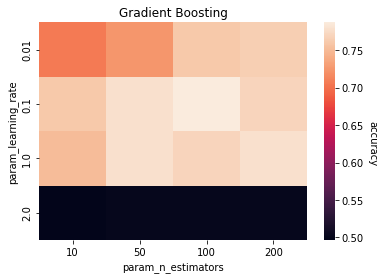

In [23]:
# Generem el model
boost = GradientBoostingClassifier(random_state = 100)

# Apliquem GridSearchCV
grid = GridSearchCV(boost, 
                    param_grid=hiperParam, 
                    cv=4, 
                    scoring='accuracy')

grid.fit(X_train, y_train)
grid.cv_results_


# Aquest és el resultat obtingut
result_pvt = pd.pivot_table(pd.DataFrame(grid.cv_results_),
         values='mean_test_score', index='param_learning_rate', columns='param_n_estimators')


ax = plt.axes()
ax.text(4.9,2.6,'accuracy', rotation = 270)
sns.heatmap(result_pvt, ax = ax )
ax.set_title('Gradient Boosting')
plt.show()

In [24]:
result_pvt

param_n_estimators,10,50,100,200
param_learning_rate,,,,
0.01,0.705925,0.724107,0.760390,0.764692
0.10,0.760308,0.778247,0.787175,0.769075
1.00,0.751055,0.778409,0.769399,0.778328
2.00,0.496753,0.501218,0.501218,0.501218


In [25]:
# Apliquem l'hiperparàmetre amb major precisió i entrenem
boost = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100, random_state = 100)

# Codecarbon + timeit
tracker = EmissionsTracker()

tracker.start()
starttime = timeit.default_timer()

boost.fit(X_train, y_train)

time = timeit.default_timer() - starttime

emissions: float = tracker.stop()

# Apliquem predict sobre test
y_pred = boost.predict(X_test)

# Pintem l'accuracy del model i la matriu de confusió
print("RESULTAT GRADIENT BOOSTING:")
print('- Accuracy: {}'.format(round(accuracy_score(y_test, y_pred)*100, 3)))
print('- Emissions C02: {}'.format(emissions))
print('- Temps: {}'.format(time))

[codecarbon INFO @ 20:48:11] [setup] RAM Tracking...
[codecarbon INFO @ 20:48:11] [setup] GPU Tracking...
[codecarbon INFO @ 20:48:11] No GPU found.
[codecarbon INFO @ 20:48:11] [setup] CPU Tracking...
[codecarbon WARNING @ 20:48:11] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 20:48:12] We saw that you have a Intel(R) Xeon(R) CPU E5-2630 v3 @ 2.40GHz but we don't know it. Please contact us.
[codecarbon INFO @ 20:48:12] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU E5-2630 v3 @ 2.40GHz
[codecarbon INFO @ 20:48:12] >>> Tracker's metadata:
[codecarbon INFO @ 20:48:12]   Platform system: Linux-5.4.0-122-generic-x86_64-with-glibc2.29
[codecarbon INFO @ 20:48:12]   Python version: 3.8.10
[codecarbon INFO @ 20:48:12]   Available RAM : 31.360 GB
[codecarbon INFO @ 20:48:12]   CPU count: 8
[codecarbon INFO @ 20:48:12]   CPU model: Intel(R) Xeon(R) CPU E5-2630 v3 @ 2.40GHz
[codecarbon INFO @ 20:48:12]   GPU count: None
[codecarbon INFO @ 20

RESULTAT GRADIENT BOOSTING:
- Accuracy: 80.357
- Emissions C02: 8.998294095032786e-07
- Temps: 0.31067110039293766


## Conclusions

- El model que ha obtingut un millor resultat ha sigut SVM amb els paràmetres C = 10 i gamma = 10

Les variables més importants en aquest model han sigut:

Text(0.5, 0, 'Permutation Importance')

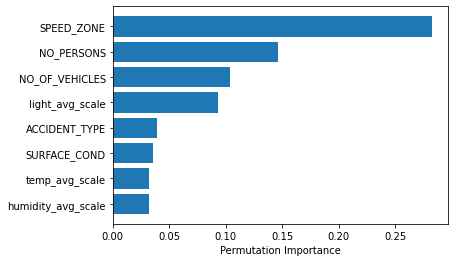

In [26]:
perm_importance = permutation_importance(classifier, X_test, y_test)

feature_names = X.columns
features = np.array(feature_names)

sorted_idx = perm_importance.importances_mean.argsort()

weight_variab              = pd.DataFrame(
                            {'variable': features[sorted_idx],
                             'pes'     : perm_importance.importances_mean[sorted_idx]}
                            )


speed_z = {'variable':'SPEED_ZONE', 'pes' : sum(weight_variab[weight_variab['variable'].str.contains("SZ")]['pes'])}

weight_variab = weight_variab.append(speed_z, ignore_index=True)

weight_variab = weight_variab[~(weight_variab['variable'].str.contains("SZ"))]

# Ordenem i pintem el resultat
weight_variab = weight_variab.sort_values('pes', ascending=True)

plt.barh(weight_variab['variable'], weight_variab['pes'])
plt.xlabel("Permutation Importance")

In [27]:
weight_variab.sort_values('pes', ascending=False)

,variable,pes
13,SPEED_ZONE,0.282143
12,NO_PERSONS,0.146429
10,NO_OF_VEHICLES,0.103571
9,light_avg_scale,0.092857
5,ACCIDENT_TYPE,0.039286
4,SURFACE_COND,0.035714
3,temp_avg_scale,0.032143
2,humidity_avg_scale,0.032143


## NEXT STEPS - REDUCCIÓ DE DIMENSIONALITAT

In [28]:
X = acc_meas[['SURFACE_COND', 'SZ_40','SZ_50','SZ_60','SZ_70','SZ_80','SZ_100', 'NO_OF_VEHICLES', 'NO_PERSONS', 'light_avg_scale']]
y = acc_meas['SEVERITY']


X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0)

## K - NN

In [29]:
# Establim els paràmetres
k     = list(range(1,11))
pesos = ['uniform','distance']
hiperParam = dict(n_neighbors=k, weights=pesos)

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"


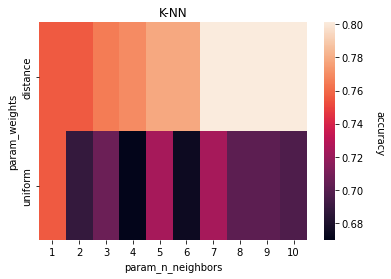

param_n_neighbors,1,2,3,4,5,6,7,8,9,10
param_weights,,,,,,,,,,
distance,0.755763,0.755763,0.764854,0.769399,0.778490,0.778490,0.801136,0.801136,0.801136,0.801136
uniform,0.755763,0.687987,0.706169,0.669805,0.723945,0.674107,0.723864,0.701299,0.701218,0.696834


In [30]:
# Generem el model
knn = KNeighborsClassifier(n_neighbors=10)

# Apliquem GridSearchCV
grid = GridSearchCV(knn, 
                    param_grid=hiperParam, 
                    cv=4, 
                    scoring='accuracy')

# Entrenem
grid.fit(X_train, y_train)

# Resultat
# Aquest és el resultat obtingut
result_pvt = pd.pivot_table(pd.DataFrame(grid.cv_results_),
         values='mean_test_score', index='param_weights', columns='param_n_neighbors')

ax = plt.axes()
ax.text(12.5,1.20,'accuracy', rotation = 270)
sns.heatmap(result_pvt, ax = ax )     
ax.set_title('K-NN')
plt.show()
result_pvt

In [31]:
# n_neighbors=10
# weights='distance'
# Apliquem l'hiperparàmetre amb major precisió i entrenem
knn = KNeighborsClassifier(n_neighbors=10, weights='distance')

# Codecarbon + timeit

tracker = EmissionsTracker()

tracker.start()
starttime = timeit.default_timer()

knn.fit(X_train, y_train)

time = timeit.default_timer() - starttime

emissions: float = tracker.stop()

# Apliquem predict sobre test
y_pred = knn.predict(X_test)

# Pintem l'accuracy del model i la matriu de confusió
print("RESULTAT K-NN :")
print('- Accuracy: {}'.format(round(accuracy_score(y_test, y_pred)*100, 3)))
print('- Emissions C02: {}'.format(emissions))
print('- Temps: {}'.format(time))

[codecarbon INFO @ 20:48:16] [setup] RAM Tracking...
[codecarbon INFO @ 20:48:16] [setup] GPU Tracking...
[codecarbon INFO @ 20:48:16] No GPU found.
[codecarbon INFO @ 20:48:16] [setup] CPU Tracking...
[codecarbon WARNING @ 20:48:16] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 20:48:18] We saw that you have a Intel(R) Xeon(R) CPU E5-2630 v3 @ 2.40GHz but we don't know it. Please contact us.
[codecarbon INFO @ 20:48:18] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU E5-2630 v3 @ 2.40GHz
[codecarbon INFO @ 20:48:18] >>> Tracker's metadata:
[codecarbon INFO @ 20:48:18]   Platform system: Linux-5.4.0-122-generic-x86_64-with-glibc2.29
[codecarbon INFO @ 20:48:18]   Python version: 3.8.10
[codecarbon INFO @ 20:48:18]   Available RAM : 31.360 GB
[codecarbon INFO @ 20:48:18]   CPU count: 8
[codecarbon INFO @ 20:48:18]   CPU model: Intel(R) Xeon(R) CPU E5-2630 v3 @ 2.40GHz
[codecarbon INFO @ 20:48:18]   GPU count: None
[codecarbon INFO @ 20

RESULTAT K-NN :
- Accuracy: 83.929
- Emissions C02: 1.5319803807497262e-08
- Temps: 0.0034732241183519363


## SVM

In [32]:
# Establim els paràmetres
C_param     = [0.01, 0.1, 1, 10, 50, 100, 200]
gamma_param = [0.001, 0.01, 0.1, 1, 10]
hiperParam = dict(C=C_param, gamma=gamma_param)

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"


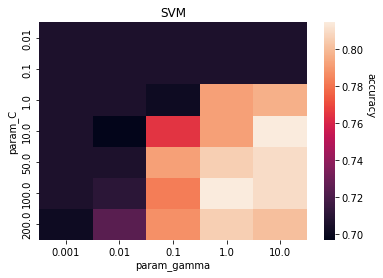

param_gamma,0.001,0.010,0.100,1.000,10.000
param_C,,,,,
0.01,0.705925,0.705925,0.705925,0.705925,0.705925
0.10,0.705925,0.705925,0.705925,0.705925,0.705925
1.00,0.705925,0.705925,0.701461,0.791721,0.796429
10.00,0.705925,0.696916,0.764773,0.791964,0.814529
50.00,0.705925,0.706006,0.791721,0.805519,0.809903
100.00,0.705925,0.710552,0.782630,0.814529,0.809903
200.00,0.701461,0.724107,0.787500,0.805438,0.800893


In [33]:
# Generem el model
classifier = svm.SVC(kernel="rbf")

# Apliquem GridSearchCV
grid = GridSearchCV(classifier, 
                    param_grid=hiperParam, 
                    cv=4, 
                    scoring='accuracy')

grid.fit(X_train, y_train)
grid.cv_results_

# Resultat
result_pvt = pd.pivot_table(pd.DataFrame(grid.cv_results_),
         values='mean_test_score', index='param_C', columns='param_gamma')

ax = plt.axes()
ax.text(6.1,3.,'accuracy', rotation = 270)
sns.heatmap(result_pvt, ax = ax )
ax.set_title('SVM')
plt.show()
result_pvt

In [34]:
#C = 10
#GAMMA = 10

# Apliquem l'hiperparàmetre amb major precisió i entrenem
classifier = svm.SVC(kernel="rbf", C=10, gamma=10, probability=True)

# Codecarbon + timeit

tracker = EmissionsTracker()

tracker.start()
starttime = timeit.default_timer()

classifier.fit(X_train, y_train)

time = timeit.default_timer() - starttime

emissions: float = tracker.stop()

# Apliquem predict sobre test
y_pred = classifier.predict(X_test)

# Pintem l'accuracy del model i la matriu de confusió
print("RESULTAT SVM :")
print('- Accuracy: {}'.format(round(accuracy_score(y_test, y_pred)*100, 3)))
print('- Emissions C02: {}'.format(emissions))
print('- Temps: {}'.format(time))

[codecarbon INFO @ 20:48:23] [setup] RAM Tracking...
[codecarbon INFO @ 20:48:23] [setup] GPU Tracking...
[codecarbon INFO @ 20:48:23] No GPU found.
[codecarbon INFO @ 20:48:23] [setup] CPU Tracking...
[codecarbon WARNING @ 20:48:23] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 20:48:24] We saw that you have a Intel(R) Xeon(R) CPU E5-2630 v3 @ 2.40GHz but we don't know it. Please contact us.
[codecarbon INFO @ 20:48:24] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU E5-2630 v3 @ 2.40GHz
[codecarbon INFO @ 20:48:24] >>> Tracker's metadata:
[codecarbon INFO @ 20:48:24]   Platform system: Linux-5.4.0-122-generic-x86_64-with-glibc2.29
[codecarbon INFO @ 20:48:24]   Python version: 3.8.10
[codecarbon INFO @ 20:48:24]   Available RAM : 31.360 GB
[codecarbon INFO @ 20:48:24]   CPU count: 8
[codecarbon INFO @ 20:48:24]   CPU model: Intel(R) Xeon(R) CPU E5-2630 v3 @ 2.40GHz
[codecarbon INFO @ 20:48:24]   GPU count: None
[codecarbon INFO @ 20

RESULTAT SVM :
- Accuracy: 85.714
- Emissions C02: 5.701919319502875e-08
- Temps: 0.018500405363738537


## Arbre de decisió

In [35]:
# Establim els paràmetres
max_depth_param         = list(range(4,11))
min_samples_split_param = [2, 10, 20, 50, 100]
hiperParam = dict(max_depth = max_depth_param, min_samples_split = min_samples_split_param)

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"


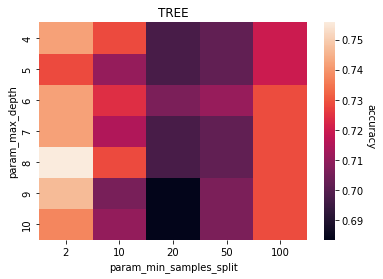

param_min_samples_split,2,10,20,50,100
param_max_depth,,,,,
4,0.742127,0.728490,0.697078,0.701705,0.719643
5,0.728490,0.710308,0.697078,0.701705,0.719643
6,0.742127,0.723945,0.706169,0.710795,0.728734
7,0.741964,0.714773,0.697078,0.701705,0.728734
8,0.755682,0.728409,0.697078,0.701705,0.728734
9,0.746591,0.705682,0.683442,0.706250,0.728734
10,0.737581,0.710227,0.683442,0.706250,0.728734


In [36]:
# Generem el model
tree = DecisionTreeClassifier(random_state = 100)

# Apliquem GridSearchCV
grid = GridSearchCV(tree, 
                    param_grid=hiperParam, 
                    cv=4, 
                    scoring='accuracy')

grid.fit(X_train, y_train)
grid.cv_results_

# Resultat
result_pvt = pd.pivot_table(pd.DataFrame(grid.cv_results_),
         values='mean_test_score', index='param_max_depth', columns='param_min_samples_split')

ax = plt.axes()
sns.heatmap(result_pvt, ax = ax )
ax.text(6.1,4,'accuracy', rotation = 270)
ax.set_title('TREE')
plt.show()
result_pvt

In [37]:
#max_depth = 8
#min_samples_split = 2

# Apliquem l'hiperparàmetre amb major precisió i entrenem
tree = DecisionTreeClassifier(max_depth = 8, min_samples_split = 2, random_state = 100)

# Codecarbon + timeit

tracker = EmissionsTracker()

tracker.start()
starttime = timeit.default_timer()

tree.fit(X_train, y_train)

time = timeit.default_timer() - starttime

emissions: float = tracker.stop()

# Apliquem predict sobre test
y_pred = tree.predict(X_test)

# Pintem l'accuracy del model i la matriu de confusió
print("RESULTAT TREE :")
print('- Accuracy: {}'.format(round(accuracy_score(y_test, y_pred)*100, 3)))
print('- Emissions C02: {}'.format(emissions))
print('- Temps: {}'.format(time))

[codecarbon INFO @ 20:48:26] [setup] RAM Tracking...
[codecarbon INFO @ 20:48:26] [setup] GPU Tracking...
[codecarbon INFO @ 20:48:26] No GPU found.
[codecarbon INFO @ 20:48:26] [setup] CPU Tracking...
[codecarbon WARNING @ 20:48:26] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 20:48:27] We saw that you have a Intel(R) Xeon(R) CPU E5-2630 v3 @ 2.40GHz but we don't know it. Please contact us.
[codecarbon INFO @ 20:48:27] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU E5-2630 v3 @ 2.40GHz
[codecarbon INFO @ 20:48:27] >>> Tracker's metadata:
[codecarbon INFO @ 20:48:27]   Platform system: Linux-5.4.0-122-generic-x86_64-with-glibc2.29
[codecarbon INFO @ 20:48:27]   Python version: 3.8.10
[codecarbon INFO @ 20:48:27]   Available RAM : 31.360 GB
[codecarbon INFO @ 20:48:27]   CPU count: 8
[codecarbon INFO @ 20:48:27]   CPU model: Intel(R) Xeon(R) CPU E5-2630 v3 @ 2.40GHz
[codecarbon INFO @ 20:48:27]   GPU count: None
[codecarbon INFO @ 20

RESULTAT TREE :
- Accuracy: 78.571
- Emissions C02: 2.327349302897296e-08
- Temps: 0.0058031268417835236


## Random Forest

In [38]:
# Establim els paràmetres
max_depth_param    = list(range(4,13))
n_estimators_param = [10, 20, 50, 100, 200]
hiperParam = dict(max_depth = max_depth_param, n_estimators = n_estimators_param)

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"


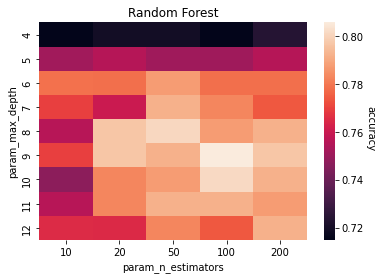

param_n_estimators,10,20,50,100,200
param_max_depth,,,,,
4,0.714854,0.719399,0.719399,0.714854,0.723945
5,0.751055,0.755601,0.750974,0.750974,0.755519
6,0.778409,0.778328,0.787338,0.778247,0.778328
7,0.769481,0.760227,0.791964,0.782955,0.773864
8,0.755763,0.796510,0.800974,0.787419,0.792045
9,0.769481,0.796591,0.792045,0.805682,0.796591
10,0.746834,0.782955,0.787500,0.801136,0.792045
11,0.755844,0.782955,0.792045,0.792045,0.787500
12,0.764935,0.764773,0.782955,0.773864,0.792045


In [39]:
# Generem el model que volem
classif= RandomForestClassifier(random_state = 100)

# Apliquem GridSearchCV
grid = GridSearchCV(classif, 
                    param_grid=hiperParam, 
                    cv=4, 
                    scoring='accuracy')

grid.fit(X_train, y_train)
grid.cv_results_


# Aquest és el resultat obtingut
result_pvt = pd.pivot_table(pd.DataFrame(grid.cv_results_),
         values='mean_test_score', index='param_max_depth', columns='param_n_estimators')


ax = plt.axes()
ax.text(6.1,5.2,'accuracy', rotation = 270)
sns.heatmap(result_pvt, ax = ax )
ax.set_title('Random Forest')
plt.show()
result_pvt

In [40]:
#max_depth = 9
#n_estimators = 100 
#Apliquem l'hiperparàmetre amb major precisió i entrenem
randomf = RandomForestClassifier(max_depth=9, n_estimators=100, random_state = 100)

# Codecarbon + timeit

tracker = EmissionsTracker()

tracker.start()
starttime = timeit.default_timer()

randomf.fit(X_train, y_train)

time = timeit.default_timer() - starttime

emissions: float = tracker.stop()

# Apliquem predict sobre test
y_pred = randomf.predict(X_test)

# Pintem l'accuracy del model i la matriu de confusió
print("RESULTAT RANDOM FOREST :")
print('- Accuracy: {}'.format(round(accuracy_score(y_test, y_pred)*100, 3)))
print('- Emissions C02: {}'.format(emissions))
print('- Temps: {}'.format(time))

[codecarbon INFO @ 20:48:50] [setup] RAM Tracking...
[codecarbon INFO @ 20:48:50] [setup] GPU Tracking...
[codecarbon INFO @ 20:48:50] No GPU found.
[codecarbon INFO @ 20:48:50] [setup] CPU Tracking...
[codecarbon WARNING @ 20:48:50] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 20:48:52] We saw that you have a Intel(R) Xeon(R) CPU E5-2630 v3 @ 2.40GHz but we don't know it. Please contact us.
[codecarbon INFO @ 20:48:52] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU E5-2630 v3 @ 2.40GHz
[codecarbon INFO @ 20:48:52] >>> Tracker's metadata:
[codecarbon INFO @ 20:48:52]   Platform system: Linux-5.4.0-122-generic-x86_64-with-glibc2.29
[codecarbon INFO @ 20:48:52]   Python version: 3.8.10
[codecarbon INFO @ 20:48:52]   Available RAM : 31.360 GB
[codecarbon INFO @ 20:48:52]   CPU count: 8
[codecarbon INFO @ 20:48:52]   CPU model: Intel(R) Xeon(R) CPU E5-2630 v3 @ 2.40GHz
[codecarbon INFO @ 20:48:52]   GPU count: None
[codecarbon INFO @ 20

RESULTAT RANDOM FOREST :
- Accuracy: 82.143
- Emissions C02: 4.140422039874731e-07
- Temps: 0.1428416408598423


## Gradient Boosting

In [41]:
# Establim els paràmetres indicats a l'enunciat
learning_rate_param = [0.01, 0.1, 1, 2]
n_estimators_param  = [10, 50, 100, 200]
hiperParam = dict(learning_rate = learning_rate_param, n_estimators = n_estimators_param)

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"


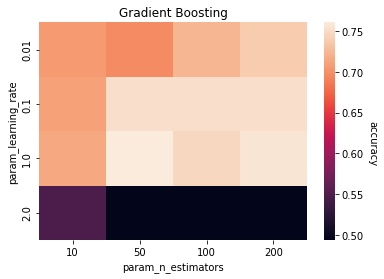

param_n_estimators,10,50,100,200
param_learning_rate,,,,
0.01,0.705925,0.696916,0.724026,0.737662
0.10,0.710471,0.751299,0.751461,0.751299
1.00,0.715097,0.760471,0.746834,0.755844
2.00,0.547727,0.494156,0.494156,0.494156


In [42]:
# Generem el model
boost = GradientBoostingClassifier(random_state = 100)

# Apliquem GridSearchCV
grid = GridSearchCV(boost, 
                    param_grid=hiperParam, 
                    cv=4, 
                    scoring='accuracy')

grid.fit(X_train, y_train)
grid.cv_results_


# Aquest és el resultat obtingut
result_pvt = pd.pivot_table(pd.DataFrame(grid.cv_results_),
         values='mean_test_score', index='param_learning_rate', columns='param_n_estimators')


ax = plt.axes()
ax.text(4.9,2.6,'accuracy', rotation = 270)
sns.heatmap(result_pvt, ax = ax )
ax.set_title('Gradient Boosting')
plt.show()
result_pvt

In [43]:
#learning_rate 1
#n_estimators 50
# Apliquem l'hiperparàmetre amb major precisió i entrenem
boost = GradientBoostingClassifier(learning_rate=0.1, n_estimators=50, random_state = 100)

# Codecarbon + timeit
tracker = EmissionsTracker()

tracker.start()
starttime = timeit.default_timer()

boost.fit(X_train, y_train)

time = timeit.default_timer() - starttime

emissions: float = tracker.stop()

# Apliquem predict sobre test
y_pred = boost.predict(X_test)

# Pintem l'accuracy del model i la matriu de confusió
print("RESULTAT GRADIENT BOOSTING:")
print('- Accuracy: {}'.format(round(accuracy_score(y_test, y_pred)*100, 3)))
print('- Emissions C02: {}'.format(emissions))
print('- Temps: {}'.format(time))

[codecarbon INFO @ 20:49:06] [setup] RAM Tracking...
[codecarbon INFO @ 20:49:06] [setup] GPU Tracking...
[codecarbon INFO @ 20:49:06] No GPU found.
[codecarbon INFO @ 20:49:06] [setup] CPU Tracking...
[codecarbon WARNING @ 20:49:06] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 20:49:08] We saw that you have a Intel(R) Xeon(R) CPU E5-2630 v3 @ 2.40GHz but we don't know it. Please contact us.
[codecarbon INFO @ 20:49:08] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU E5-2630 v3 @ 2.40GHz
[codecarbon INFO @ 20:49:08] >>> Tracker's metadata:
[codecarbon INFO @ 20:49:08]   Platform system: Linux-5.4.0-122-generic-x86_64-with-glibc2.29
[codecarbon INFO @ 20:49:08]   Python version: 3.8.10
[codecarbon INFO @ 20:49:08]   Available RAM : 31.360 GB
[codecarbon INFO @ 20:49:08]   CPU count: 8
[codecarbon INFO @ 20:49:08]   CPU model: Intel(R) Xeon(R) CPU E5-2630 v3 @ 2.40GHz
[codecarbon INFO @ 20:49:08]   GPU count: None
[codecarbon INFO @ 20

RESULTAT GRADIENT BOOSTING:
- Accuracy: 73.214
- Emissions C02: 3.94213310033807e-07
- Temps: 0.13611170928925276


## Conclusions dades redimensionades

,variable,pes
10,SPEED_ZONE,0.239286
9,light_avg_scale,0.146429
8,NO_PERSONS,0.125000
7,NO_OF_VEHICLES,0.096429
4,SURFACE_COND,0.042857


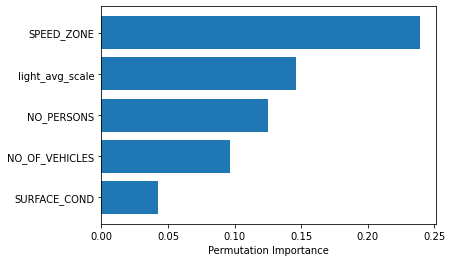

In [44]:
perm_importance = permutation_importance(classifier, X_test, y_test)

feature_names = X.columns
features = np.array(feature_names)

sorted_idx = perm_importance.importances_mean.argsort()

weight_variab              = pd.DataFrame(
                            {'variable': features[sorted_idx],
                             'pes'     : perm_importance.importances_mean[sorted_idx]}
                            )


speed_z = {'variable':'SPEED_ZONE', 'pes' : sum(weight_variab[weight_variab['variable'].str.contains("SZ")]['pes'])}

weight_variab = weight_variab.append(speed_z, ignore_index=True)

weight_variab = weight_variab[~(weight_variab['variable'].str.contains("SZ"))]

# Ordenem i pintem el resultat
weight_variab = weight_variab.sort_values('pes', ascending=True)

plt.barh(weight_variab['variable'], weight_variab['pes'])
plt.xlabel("Permutation Importance")
weight_variab.sort_values('pes', ascending=False)